In [62]:
!pip install tensorflow-addons
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.text import Tokenizer
import datetime
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, LSTM, LSTMCell
from tensorflow.keras.models import Model, Sequential
import tensorflow_addons as tfa

In [2]:
def gen_batch(batch_size=32):
    while True:
        X_batch, y_batch = [], []
        for _ in range(batch_size):
            start_date = datetime.date(1999, 9, 17)
            end_date = datetime.date(2021, 2, 11)

            time_between_dates = end_date - start_date

            days_between_dates = time_between_dates.days

            random_number_of_days = random.randrange(days_between_dates)

            random_date = start_date + datetime.timedelta(days=random_number_of_days)
            X_batch.append(str(random_date))
            y_batch.append(random_date.strftime("%b %d %Y").lower())
        yield (X_batch, y_batch)
    

In [3]:
g = gen_batch()
next(g)

(['2004-05-01',
  '2012-09-13',
  '2019-04-06',
  '2019-01-06',
  '2007-01-25',
  '2018-11-20',
  '2017-03-04',
  '2012-06-05',
  '2010-03-08',
  '2003-05-19',
  '2003-01-22',
  '2008-02-01',
  '2001-01-24',
  '2013-03-16',
  '2015-12-30',
  '2006-06-30',
  '2003-06-05',
  '2012-01-05',
  '2005-01-13',
  '2013-05-22',
  '1999-11-10',
  '2003-01-11',
  '2020-01-11',
  '2017-05-14',
  '2014-11-09',
  '2007-03-17',
  '2017-01-05',
  '2001-08-15',
  '2018-07-16',
  '2001-04-16',
  '2018-10-30',
  '2009-11-22'],
 ['may 01 2004',
  'sep 13 2012',
  'apr 06 2019',
  'jan 06 2019',
  'jan 25 2007',
  'nov 20 2018',
  'mar 04 2017',
  'jun 05 2012',
  'mar 08 2010',
  'may 19 2003',
  'jan 22 2003',
  'feb 01 2008',
  'jan 24 2001',
  'mar 16 2013',
  'dec 30 2015',
  'jun 30 2006',
  'jun 05 2003',
  'jan 05 2012',
  'jan 13 2005',
  'may 22 2013',
  'nov 10 1999',
  'jan 11 2003',
  'jan 11 2020',
  'may 14 2017',
  'nov 09 2014',
  'mar 17 2007',
  'jan 05 2017',
  'aug 15 2001',
  'jul 16 2

In [4]:
X_batch, y_batch = next(gen_batch(128))
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_batch + y_batch)

In [5]:
tokenizer.word_counts

OrderedDict([('1', 314),
             ('9', 67),
             ('-', 256),
             ('2', 414),
             ('0', 615),
             ('8', 55),
             ('3', 71),
             ('7', 59),
             ('4', 72),
             ('5', 63),
             ('6', 62),
             ('d', 15),
             ('e', 35),
             ('c', 25),
             (' ', 256),
             ('j', 26),
             ('a', 46),
             ('n', 39),
             ('p', 23),
             ('r', 23),
             ('o', 30),
             ('v', 20),
             ('u', 22),
             ('g', 5),
             ('m', 20),
             ('t', 10),
             ('s', 11),
             ('l', 7),
             ('f', 9),
             ('b', 9),
             ('y', 9)])

In [67]:
def gen_preprocessed_batch(batch_size=32):
    b_generator = gen_batch(batch_size)
    while True:
        X, y = next(b_generator)
        X = tokenizer.texts_to_sequences(X)
        y = tokenizer.texts_to_sequences(y)
        yield (np.expand_dims(np.array(X), axis=2).astype(np.float32), np.expand_dims(np.array(y), axis=2).astype(np.float32))
    

In [68]:
X, y = next(gen_preprocessed_batch(32))
print(X.shape)
print(y.shape)

(32, 10, 1)
(32, 11, 1)


In [116]:
tf.keras.backend.clear_session()

encoder = Sequential([
    LSTM(128, input_shape=[None, 1])
])

decoder = Sequential([
    LSTM(128, return_sequences=True),
    Dense(len(tokenizer.word_index) + 1, activation="softmax")
])

model = Sequential([
    encoder,
    tf.keras.layers.RepeatVector(11),
    decoder
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               66560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 11, 128)           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 11, 32)            135712    
Total params: 202,272
Trainable params: 202,272
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
history = model.fit(
    gen_preprocessed_batch(),
    epochs=32,
    steps_per_epoch=512,
    validation_data=gen_preprocessed_batch(),
    validation_steps=512,
)

Epoch 1/32
512/512 [==============================] - 20s 38ms/step - loss: 1.3174 - val_loss: 0.7810
Epoch 2/32
512/512 [==============================] - 19s 37ms/step - loss: 0.6172 - val_loss: 0.4152
Epoch 3/32
512/512 [==============================] - 19s 37ms/step - loss: 0.2907 - val_loss: 0.1826
Epoch 4/32
512/512 [==============================] - 19s 37ms/step - loss: 0.1343 - val_loss: 0.0903
Epoch 5/32
512/512 [==============================] - 19s 37ms/step - loss: 0.0935 - val_loss: 0.1461
Epoch 6/32
512/512 [==============================] - 19s 37ms/step - loss: 0.0401 - val_loss: 0.0238
Epoch 7/32
512/512 [==============================] - 19s 37ms/step - loss: 0.0173 - val_loss: 0.0124
Epoch 8/32
512/512 [==============================] - 19s 37ms/step - loss: 0.0451 - val_loss: 0.0184
Epoch 9/32
512/512 [==============================] - 19s 37ms/step - loss: 0.0093 - val_loss: 0.0063
Epoch 10/32
512/512 [==============================] - 19s 37ms/step - loss: 0.005

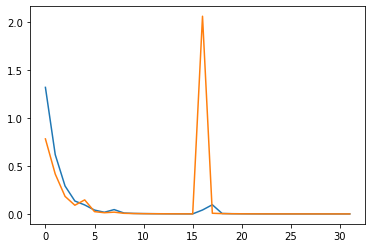

In [119]:
import matplotlib.pyplot as plt
plt.plot(list(range(32)), history.history["loss"])
plt.plot(list(range(32)), history.history["val_loss"])
plt.show()

In [120]:
x_test, y_test = next(gen_preprocessed_batch(2))
print(x_test.squeeze())
print(tokenizer.sequences_to_texts(x_test.squeeze()))
print("==================================")
print(y_test.squeeze())
print(tokenizer.sequences_to_texts(y_test.squeeze()))

[[ 2.  1.  3.  1.  4.  1.  8.  4.  1.  2.]
 [ 2.  1.  3.  8.  4.  1.  9.  4.  1. 10.]]
['2 0 1 0 - 0 9 - 0 2', '2 0 1 9 - 0 5 - 0 6']
[[25. 15. 19.  5.  1.  2.  5.  2.  1.  3.  1.]
 [23. 13. 29.  5.  1. 10.  5.  2.  1.  3.  8.]]
['s e p   0 2   2 0 1 0', 'm a y   0 6   2 0 1 9']


In [121]:
preds = model.predict_classes(x_test)

In [122]:
print(preds)
print(tokenizer.sequences_to_texts(preds))

[[25 15 19  5  1  2  5  2  1  3  1]
 [23 13 29  5  1 10  5  2  1  3  8]]
['s e p   0 2   2 0 1 0', 'm a y   0 6   2 0 1 9']


In [123]:
def convert(date, tokenizer, model):
    date_as_indices = np.expand_dims(tokenizer.texts_to_sequences([date]), axis=2)
    preds = model.predict_classes(date_as_indices)
    return tokenizer.sequences_to_texts(preds)

In [128]:
convert("2021-9-17", tokenizer, model)

['j u l   1 7   2 0 0 4']